In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

TWEET_DATA = '../data/01_raw/product_sentiment.csv'

In [2]:
df = pd.read_csv(TWEET_DATA)
df.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product': 'label'}, inplace=True)
df.head(3)

,index,tweet_text,emotion_in_tweet_is_directed_at,label
0,0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion


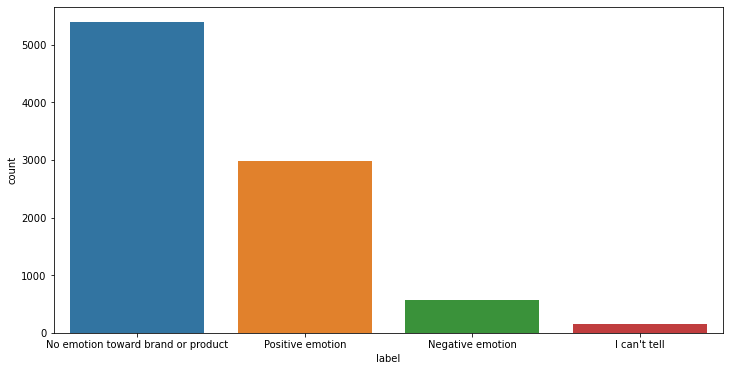

In [3]:
# look at label distribution

label = df['label'].value_counts().to_frame().T
plt.figure(figsize=(12,6))
sns.barplot(data=label)
plt.ylabel('count')
plt.xlabel('label')
plt.show()

In [4]:
# clean
df_cln = df.copy()[df['label'] != "I can't tell"]
len_before, len_after = len(df), len(df_cln)
print(f'before cln: {len_before}, after cln: {len_after}')

before cln: 9093, after cln: 8937


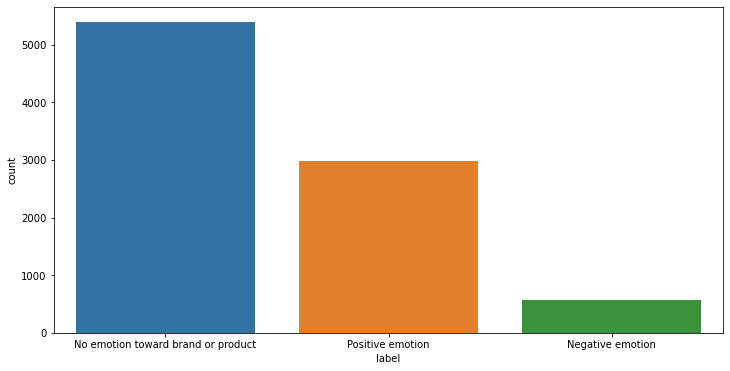

In [5]:

label = df_cln['label'].value_counts().to_frame().T
plt.figure(figsize=(12,6))
sns.barplot(data=label)
plt.ylabel('count')
plt.xlabel('label')
plt.show()

In [6]:
LABEL_MAPPING = { 
    "No emotion toward brand or product": {
        "alt_label": "NEU",
        "class": 1,
    },
    "Positive emotion": {
        "alt_label": "POS",
        "class": 2,
    },
    "Negative emotion": {
        "alt_label": "NEG",
        "class": 0,
    },
}


In [7]:
def rename_labels(row):
    row['alt_label'] = LABEL_MAPPING[row['label']]['alt_label']
    row['class'] = LABEL_MAPPING[row['label']]['class']
    return row

df_cln = df_cln.apply(rename_labels, axis=1)
df_cln.head(3)

,index,tweet_text,emotion_in_tweet_is_directed_at,label,alt_label,class
0,0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,NEG,0
1,1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,POS,2
2,2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,POS,2


#### Viz product sentiment

Try Marimekko chart - https://plotly.com/python/bar-charts/

In [8]:
# product sentiment
product_setiment = df_cln.groupby(['emotion_in_tweet_is_directed_at', 'alt_label'])['label'].count().to_frame().reset_index()

# plotly Marimekko Chart
val_counts = df_cln['emotion_in_tweet_is_directed_at'].value_counts()
labels = val_counts.index.tolist()
widths = val_counts.values

# cut labels
max_label_len = 12
labels_cut = [f'{label[0:max_label_len]}...' if len(label) > max_label_len+3 else label for label in labels]

data = {
    "NEG": [],
    "NEU": [],
    "POS": [] 
}
# this could be done better!
for label in labels:
    filter_sentiment = product_setiment[product_setiment['emotion_in_tweet_is_directed_at']==label]
    for sentiment in data.keys():
        filter_sentiment['label_scale'] = 100*filter_sentiment['label']/filter_sentiment['label'].sum()
        sentiment_count = filter_sentiment[filter_sentiment['alt_label'] == sentiment]['label_scale'].values[0]
        data[sentiment].append(sentiment_count)


/var/folders/xn/6_m94v0x6qd5830449yf6t6m0000gn/T/ipykernel_45905/1750888536.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_sentiment['label_scale'] = 100*filter_sentiment['label']/filter_sentiment['label'].sum()
/var/folders/xn/6_m94v0x6qd5830449yf6t6m0000gn/T/ipykernel_45905/1750888536.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_sentiment['label_scale'] = 100*filter_sentiment['label']/filter_sentiment['label'].sum()
/var/folders/xn/6_m94v0x6qd5830449yf6t6m0000gn/T/ipykernel_459

In [9]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure()
for key in data:
    fig.add_trace(go.Bar(
        name=key,
        y=data[key],
        x=np.cumsum(widths)-widths,
        width=widths,
        offset=0,
        customdata=np.transpose([labels, widths*data[key]]),
        texttemplate="%{y:.1f}%",
        textposition="inside",
        textangle=0,
        textfont_color="white",
        hovertemplate="<br>".join([
            "device: %{customdata[0]}",
            "number of tweets: %{width}",
            "proportion: %{y:.2f}%",
        ])
    ))

fig.update_xaxes(
    tickvals=np.cumsum(widths)-widths/2,
    ticktext= ["%s - %d tweets" % (l, w) for l, w in zip(labels_cut, widths)],
    tickangle = 45
)

fig.update_xaxes(range=[0, widths.sum()])
fig.update_yaxes(range=[0, 100])


fig.update_layout(
    title_text="Product sentiment",
    barmode="stack",
    uniformtext=dict(mode="hide", minsize=10),
    height=600,
)
